In [1]:
import numpy as np 
import pandas as pd

In [17]:
import gensim
import nltk as nl
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

# nltk.download('stopwords') ## may need to run this if errors
nltk_stopwords = stopwords.words("english")
gensim_stopwords = gensim.parsing.preprocessing.STOPWORDS
sklearn_stopwords = stop_words.ENGLISH_STOP_WORDS
combined_stopwords = sklearn_stopwords.union(nltk_stopwords,gensim_stopwords)

/anaconda3/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [18]:
print('NLTK has {} stop words'.format(len(nltk_stopwords)))
print('Gensim has {} stop words'.format(len(gensim_stopwords)))
print('Sklearn has {} stop words'.format(len(sklearn_stopwords)))
print('Combined stopwords list has {} stop words'.format(len(combined_stopwords)))

NLTK has 179 stop words
Gensim has 337 stop words
Sklearn has 318 stop words
Combined stopwords list has 390 stop words


In [19]:
from nltk.stem import PorterStemmer 
porter_stemmer = PorterStemmer() 

In [20]:
data['title'] = data['title'].apply(lambda x: x.lower()) ## change all to lower case
data['title'] = data['title'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
data['title'] = data['title'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
data['title'] = data['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

data['text'] = data['text'].apply(lambda x: x.lower()) ## change all to lower case
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
data['text'] = data['text'].apply(lambda x: ' '.join([porter_stemmer.stem(word) for word in x.split()]))
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (combined_stopwords)]))

data = data.dropna()

In [21]:
data.to_csv("./Datasets-fakenews/Fake_news_clean.csv",index=False)

In [6]:
data = pd.read_csv("./Datasets-fakenews/Fake_news_clean.csv")
data = data.dropna()

In [7]:
from sklearn.model_selection import train_test_split

x_train_title,x_test_title,y_train_title,y_test_title=train_test_split(data['title'], data['label'], test_size=0.3, random_state=7)

x_train_text,x_test_text,y_train_text,y_test_text=train_test_split(data['text'], data['label'], test_size=0.3, random_state=7)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [9]:
# nltk.download('punkt') ## may need to run this if errors

tfidf_vectorizer_title = TfidfVectorizer(tokenizer = word_tokenize)
tfidf_train_title = tfidf_vectorizer_title.fit_transform(x_train_title)
tfidf_test_title = tfidf_vectorizer_title.transform(x_test_title)
tfidf_features_title = tfidf_vectorizer_title.get_feature_names()

tfidf_vectorizer_text = TfidfVectorizer(tokenizer = word_tokenize)
tfidf_train_text = tfidf_vectorizer_text.fit_transform(x_train_text)
tfidf_test_text = tfidf_vectorizer_text.transform(x_test_text)
tfidf_features_text = tfidf_vectorizer_text.get_feature_names()

In [10]:
from scipy.sparse import hstack, vstack

rf = RandomForestClassifier() ### no size criteria

tfidf_train = hstack((tfidf_train_title, tfidf_train_text))
y_train = pd.concat([y_train_title, y_train_text], axis=1).reindex(y_train_title.index)

rf.fit(tfidf_train, y_train)

tfidf_test = hstack((tfidf_test_title, tfidf_test_text))
y_test = pd.concat([y_test_title, y_test_text], axis=1).reindex(y_test_title.index)

print("Testing Acc. of Random Forest: {} %".format(round(rf.score(tfidf_test, y_test) * 100, 2)))

Testing Acc. of Random Forest: 90.17 %


In [11]:
from scipy.sparse import hstack
score_train = rf.predict_proba(tfidf_train)
score_test = rf.predict_proba(tfidf_test)

d = {'title': list(x_train_title) + list(x_test_title), 
     'text': list(x_train_text) + list(x_test_text),
     'score': list(score_train[0][:, 1]) + list(score_test[0][:, 1]),
     'label':list(y_train_title) + list(y_test_title)}
new_data = pd.DataFrame(data=d)

new_data.to_csv("./Datasets-fakenews/Fake_news_score_full.csv",index=False)

In [12]:
import pickle

# Save rf model
print("Size of the file", len(pickle.dumps(rf, -1)))
print("Hyperparameters:\n", rf.get_params())
pickle.dump(rf, open('rf_model_full.p', 'wb'))

# load the model from disk
# loaded_model = pickle.load(open('rf_model.p', 'rb'))

import matplotlib.pyplot as plt

new_data = pd.read_csv("./Datasets-fakenews/Fake_news_score_full.csv")
x_vals = abs(new_data['score'] - new_data['label'])

n, bins, patches = plt.hist(x=x_vals, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

Size of the file 383746215
Hyperparameters:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [13]:
clean_data = pd.read_csv("./Datasets-fakenews/Fake_news_score_full.csv")
clean_data = clean_data.dropna()
countNull = [clean_data['title'].isnull().values.sum(), 
             clean_data['text'].isnull().values.sum(),
             clean_data['score'].isnull().values.sum(),
             clean_data['label'].isnull().values.sum()]

print(countNull)

clean_data.to_csv("./Datasets-fakenews/Fake_news_score_full_clean.csv",index=False)

[0, 0, 0, 0]


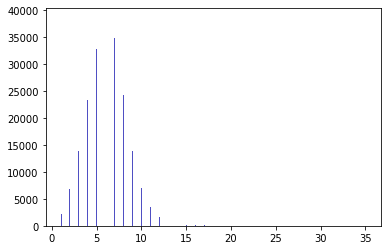

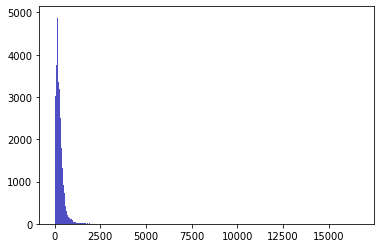

Mean, Median: Title Length [6.17054043885922, 6]
Mean, Median: Text Length [273.91791055714896, 214]


In [14]:
trial_pd = pd.read_csv("./Datasets-fakenews/Fake_news_score_full_clean.csv")

title_lens = [len(str(item).split(" ")) for item in list(trial_pd['title'])]
text_lens = [len(str(item).split(" ")) for item in list(trial_pd['text'])]

import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=title_lens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.show()

n, bins, patches = plt.hist(x=text_lens, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.show()

import statistics

print("Mean, Median: Title Length", [statistics.mean(title_lens), statistics.median(title_lens)])
print("Mean, Median: Text Length", [statistics.mean(text_lens), statistics.median(text_lens)])